# Klasifikasi Koin Rupiah

Mengklasifikasikan koin rupiah (Rp 100, 200, 500, 1000) menggunakan Edge Detection + Machine Learning.

**Dokumentasi lengkap**: Lihat [COIN-README.md](./COIN-README.md)

## 1. Import Libraries

In [56]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append(str(Path('../src').resolve()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## 2. Setup Paths dan Konfigurasi

Perbaikan: Image size 512×512, balance dataset (150 img/class), filter circle detection.

In [57]:
# Directories
BASE_DIR = Path('..').resolve()
DATASET_DIR = BASE_DIR / 'dataset'
RESULTS_DIR = BASE_DIR / 'results' / 'coin_classification'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / 'confusion_matrix').mkdir(exist_ok=True)
(RESULTS_DIR / 'visualizations').mkdir(exist_ok=True)

# Configuration
IMAGE_SIZE = (512, 512)
MAX_IMAGES_PER_CLASS = 150
RANDOM_SEED = 42
TEST_SIZE = 0.2

np.random.seed(RANDOM_SEED)

print(f"Config: {IMAGE_SIZE}, max {MAX_IMAGES_PER_CLASS} imgs/class, test {TEST_SIZE*100}%")

Config: (512, 512), max 150 imgs/class, test 20.0%


## 3. Fungsi Preprocessing Koin

In [58]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    to normalize lighting variations across images.
    """
    if len(image.shape) == 3:
        # For color images, convert to LAB and apply CLAHE on L channel
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge([l_clahe, a, b])
        result = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    else:
        # For grayscale images, apply CLAHE directly
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        result = clahe.apply(image)
    return result


def apply_canny_edge(image, use_clahe=True):
    """Apply Canny edge detection with optional CLAHE normalization"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Apply CLAHE to normalize lighting before edge detection
    if use_clahe:
        gray = apply_clahe(gray)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges


def apply_sobel_edge(image, use_clahe=True):
    """Apply Sobel edge detection with optional CLAHE normalization"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Apply CLAHE to normalize lighting before edge detection
    if use_clahe:
        gray = apply_clahe(gray)
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_combined = np.uint8(sobel_combined / sobel_combined.max() * 255)
    return sobel_combined


def detect_and_segment_coin(image, edge_method='canny', use_clahe=True):
    """Detect coin using Hough Circle Transform and segment it"""
    if edge_method == 'canny':
        edges = apply_canny_edge(image, use_clahe=use_clahe)
    else:
        edges = apply_sobel_edge(image, use_clahe=use_clahe)
    
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=50,
        param1=100,
        param2=30,
        minRadius=20,
        maxRadius=200
    )
    
    segmented = image.copy()
    circle_info = None
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circle = circles[0, 0]
        x, y, radius = circle[0], circle[1], circle[2]
        circle_info = (x, y, radius)
        
        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.circle(mask, (x, y), radius, 255, -1)
        
        if len(image.shape) == 3:
            segmented = cv2.bitwise_and(image, image, mask=mask)
        else:
            segmented = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented, circle_info, edges

## 4. Fungsi Feature Extraction

In [59]:
def extract_coin_features(segmented_image, edges, circle_info):
    """Extract comprehensive features from segmented coin (41 features total)"""
    features = []
    
    if len(segmented_image.shape) == 3:
        gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = segmented_image
    
    # 1. TEXTURE FEATURES (12 features)
    edge_density = np.sum(edges > 0) / edges.size
    features.append(edge_density)
    
    edge_mean = np.mean(edges)
    edge_std = np.std(edges)
    edge_max = np.max(edges)
    features.extend([edge_mean, edge_std, edge_max])
    
    edge_hist, _ = np.histogram(edges.flatten(), bins=8, range=(0, 256))
    edge_hist = edge_hist / (edge_hist.sum() + 1e-6)
    features.extend(edge_hist)
    
    # 2. SHAPE FEATURES (4 features)
    if circle_info is not None:
        x, y, radius = circle_info
        normalized_radius = radius / max(gray.shape)
        features.append(normalized_radius)
        
        center_x = x / gray.shape[1]
        center_y = y / gray.shape[0]
        features.extend([center_x, center_y])
        
        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.circle(mask, (x, y), radius, 255, -1)
        masked_edges = cv2.bitwise_and(edges, edges, mask=mask)
        
        contours, _ = cv2.findContours(masked_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            largest_contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(largest_contour)
            perimeter = cv2.arcLength(largest_contour, True)
            if perimeter > 0:
                circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6)
            else:
                circularity = 0
            features.append(circularity)
        else:
            features.append(0)
    else:
        features.extend([0, 0, 0, 0])
    
    # 3. EDGE PATTERN FEATURES (12 features)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    direction = np.arctan2(sobel_y, sobel_x)
    
    orientation_hist, _ = np.histogram(
        direction[magnitude > magnitude.mean()],
        bins=8,
        range=(-np.pi, np.pi)
    )
    orientation_hist = orientation_hist / (orientation_hist.sum() + 1e-6)
    features.extend(orientation_hist)
    
    features.extend([
        np.mean(magnitude),
        np.std(magnitude),
        np.percentile(magnitude, 75),
        np.percentile(magnitude, 90)
    ])
    
    # 4. SPATIAL FEATURES (4 features)
    h, w = edges.shape
    quadrants = [
        edges[0:h//2, 0:w//2],
        edges[0:h//2, w//2:w],
        edges[h//2:h, 0:w//2],
        edges[h//2:h, w//2:w]
    ]
    
    for quad in quadrants:
        quad_density = np.sum(quad > 0) / quad.size if quad.size > 0 else 0
        features.append(quad_density)
    
    # 5. TEXTURE FEATURES (3 features)
    kernel_size = 5
    local_mean = cv2.blur(gray.astype(float), (kernel_size, kernel_size))
    local_var = cv2.blur((gray.astype(float) - local_mean)**2, (kernel_size, kernel_size))
    
    features.extend([
        np.mean(local_var),
        np.std(local_var),
        np.percentile(local_var, 75)
    ])
    
    return np.array(features, dtype=np.float32)

## 5. Fungsi Data Augmentation

In [60]:
def augment_image(image):
    """Apply augmentation: rotation, flip, brightness (8x total)"""
    augmented = [image]
    
    for angle in [90, 180, 270]:
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented.append(rotated)
    
    flipped_h = cv2.flip(image, 1)
    flipped_v = cv2.flip(image, 0)
    augmented.extend([flipped_h, flipped_v])
    
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    dark = cv2.convertScaleAbs(image, alpha=0.8, beta=-20)
    augmented.extend([bright, dark])
    
    return augmented

## 6. Load dan Eksplorasi Dataset

In [61]:
class_names = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])
print(f"Classes: {class_names}")

for cls_name in class_names:
    cls_dir = DATASET_DIR / cls_name
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
    print(f"{cls_name}: {len(images)} images")

Classes: ['Koin Rp 100', 'Koin Rp 1000', 'Koin Rp 200', 'Koin Rp 500']
Koin Rp 100: 161 images
Koin Rp 1000: 219 images
Koin Rp 200: 173 images
Koin Rp 500: 211 images


## 7. Visualisasi Sample Dataset

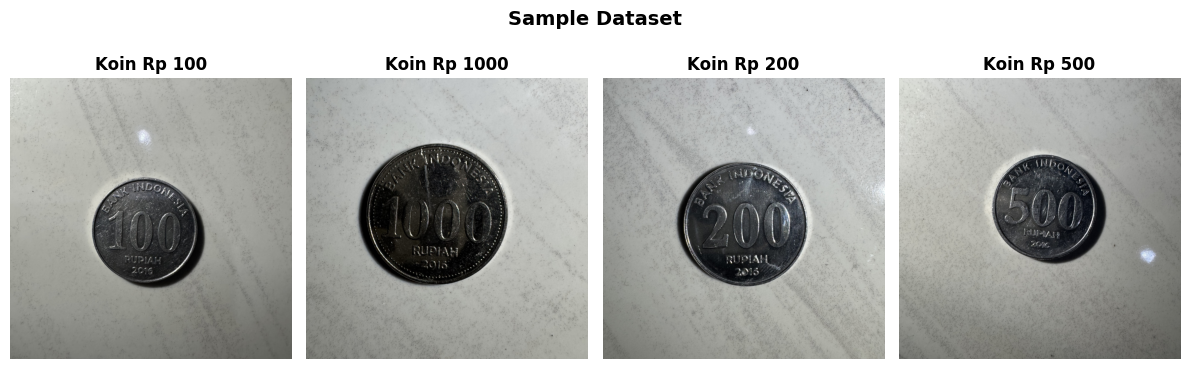

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for idx, cls_name in enumerate(class_names):
    cls_dir = DATASET_DIR / cls_name
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
    
    if images:
        img_path = images[0]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(cls_name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('Sample Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Visualisasi Pipeline Preprocessing Lengkap

Menampilkan: Original → Edge Detection → Hough Circle → Segmented → Cropped (final input for feature extraction)

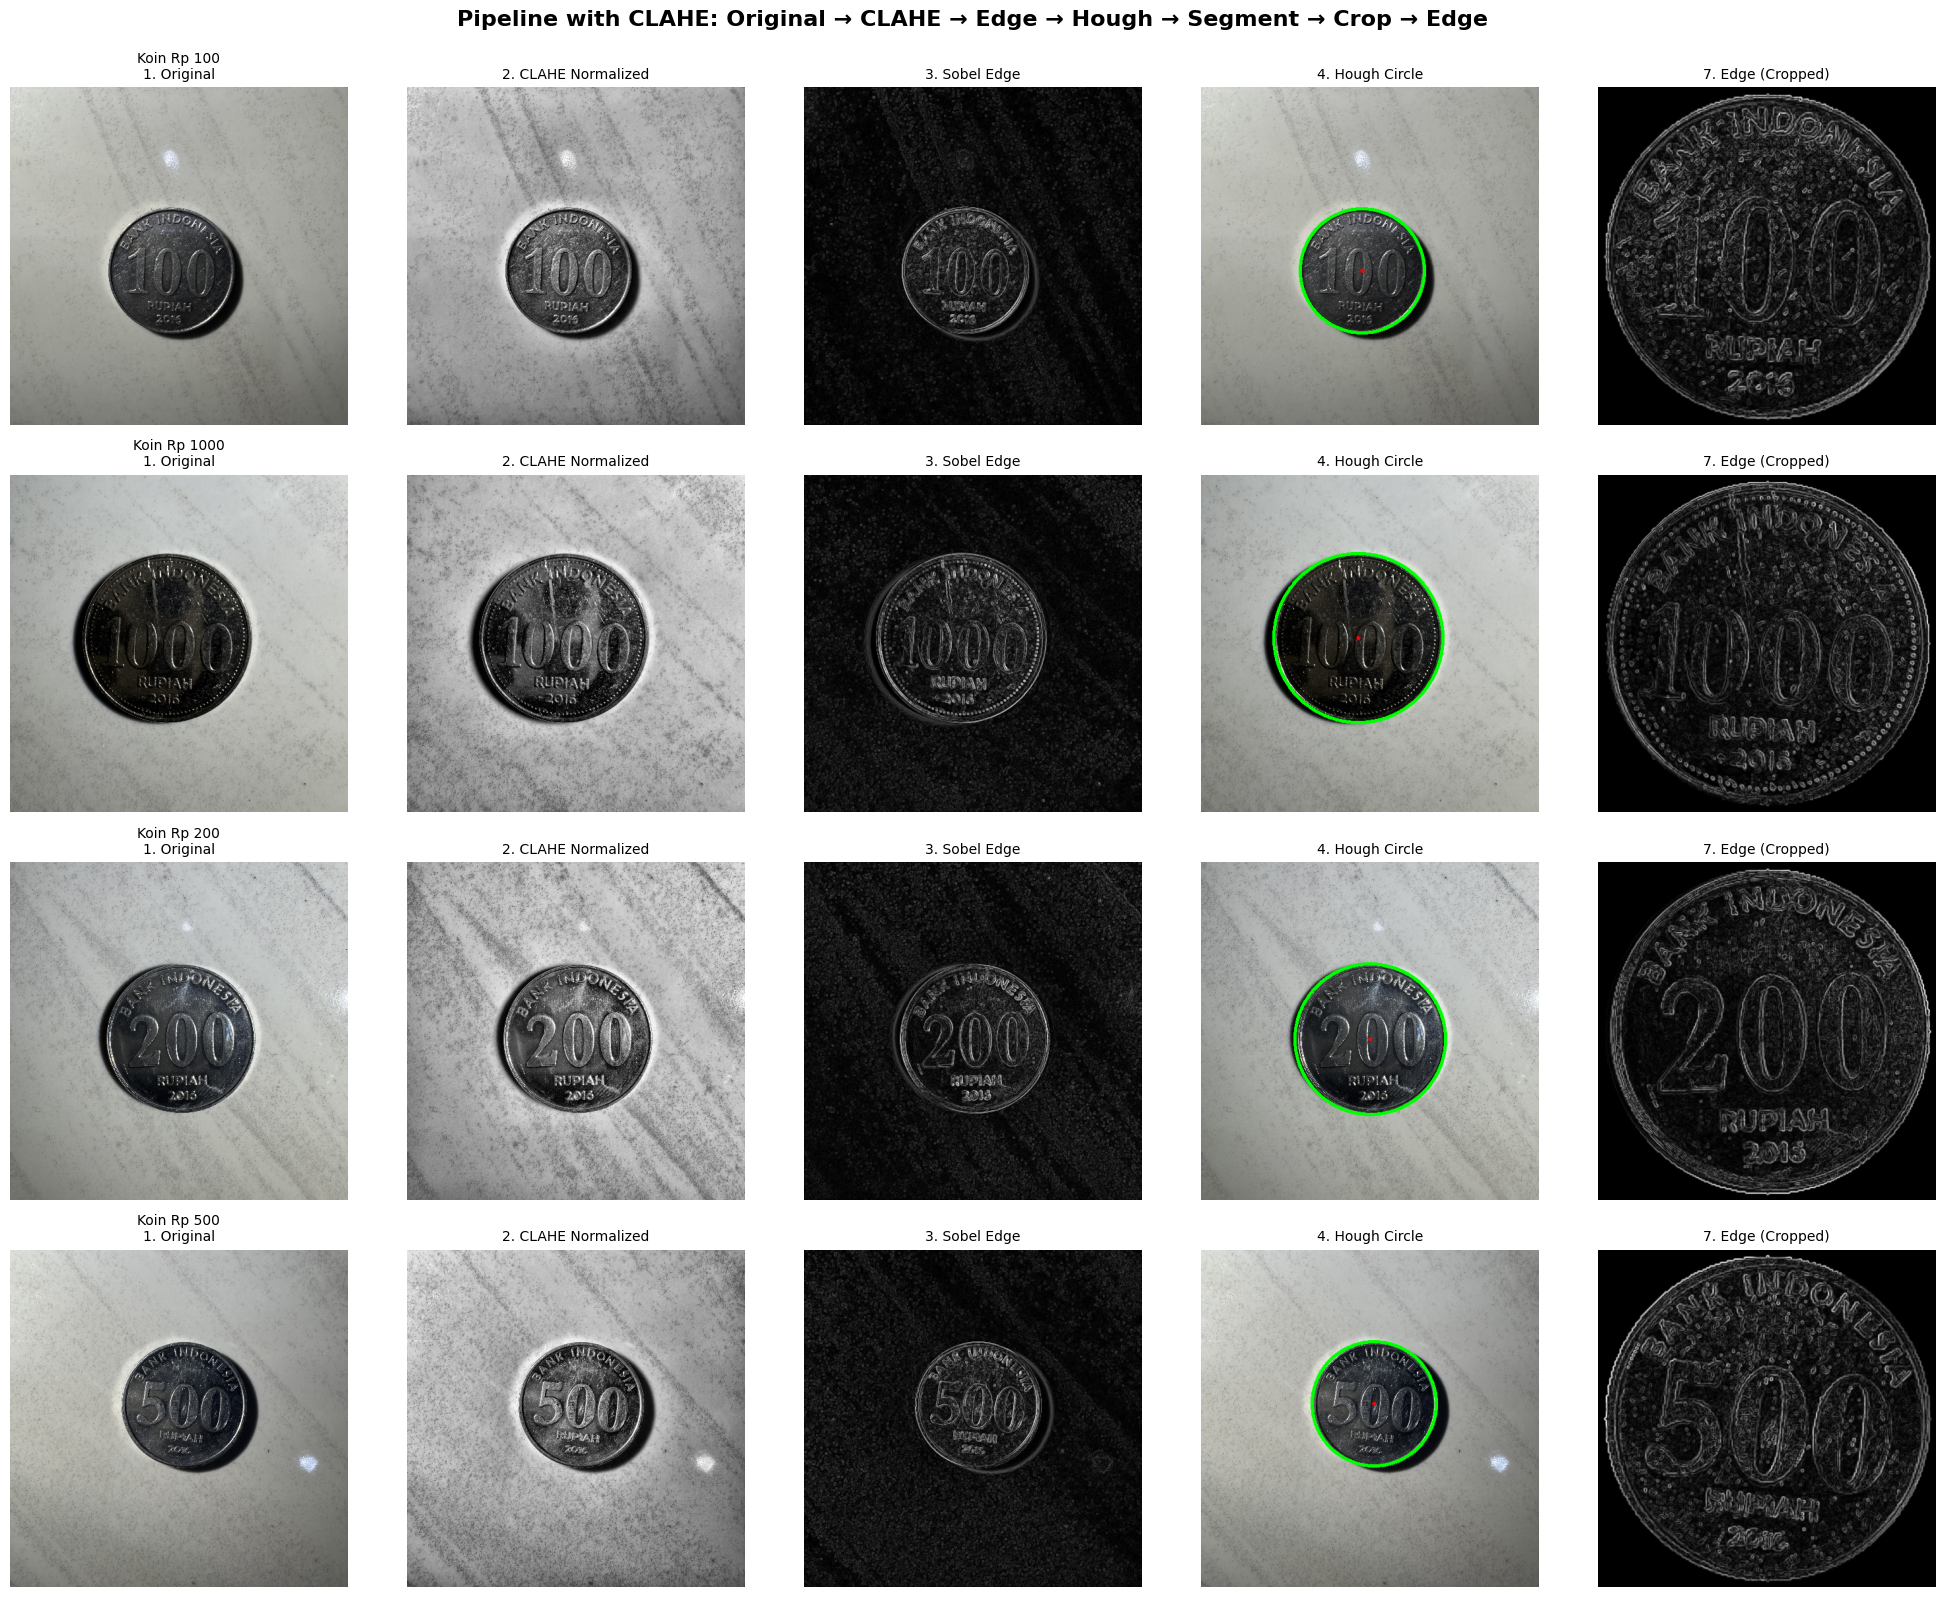


Pipeline Summary (with CLAHE):
1. Original: Load and resize to 512x512
2. CLAHE: Apply Contrast Limited Adaptive Histogram Equalization to normalize lighting
3. Sobel Edge: Detect edges on CLAHE-normalized image
4. Hough Circle: Detect coin boundary (on blurred grayscale)
5. Segmented: Apply circular mask to isolate coin
6. Cropped: Crop to circle bounding box and resize to 512x512
7. Edge (Cropped): Edge detection on cropped image for feature extraction


In [87]:
# Import crop function
import sys
sys.path.insert(0, str(Path('..').resolve()))
from preprocessing import crop_coin_to_circle

# Visualize complete preprocessing pipeline with CLAHE
fig, axes = plt.subplots(len(class_names), 5, figsize=(20, len(class_names) * 4))

for idx, cls_name in enumerate(class_names):
    cls_dir = DATASET_DIR / cls_name
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
    
    if images:
        img_path = images[0]
        img = cv2.imread(str(img_path))
        img_resized = cv2.resize(img, IMAGE_SIZE)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        
        # Show CLAHE normalization effect
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        gray_clahe = apply_clahe(gray)
        
        # Apply Sobel edge detection with CLAHE (our main method)
        segmented, circle_info, edges = detect_and_segment_coin(img_resized, edge_method='sobel', use_clahe=True)
        
        # Draw circle on original for visualization
        img_with_circle = img_resized.copy()
        if circle_info:
            x, y, r = circle_info
            cv2.circle(img_with_circle, (x, y), r, (0, 255, 0), 3)
            cv2.circle(img_with_circle, (x, y), 3, (0, 0, 255), -1)
        
        # Crop to circle diameter
        cropped = crop_coin_to_circle(segmented, circle_info, IMAGE_SIZE)
        
        # Apply edge detection to cropped version (with CLAHE)
        edges_cropped = apply_sobel_edge(cropped, use_clahe=True)
        
        # Plot pipeline
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].set_title(f'{cls_name}\n1. Original', fontsize=10)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(gray_clahe, cmap='gray')
        axes[idx, 1].set_title('2. CLAHE Normalized', fontsize=10)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(edges, cmap='gray')
        axes[idx, 2].set_title('3. Sobel Edge', fontsize=10)
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(cv2.cvtColor(img_with_circle, cv2.COLOR_BGR2RGB))
        axes[idx, 3].set_title('4. Hough Circle', fontsize=10)
        axes[idx, 3].axis('off')
        
        # axes[idx, 4].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
        # axes[idx, 4].set_title('5. Segmented', fontsize=10)
        # axes[idx, 4].axis('off')
        
        # axes[idx, 5].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        # axes[idx, 5].set_title('6. Cropped (512x512)', fontsize=10)
        # axes[idx, 5].axis('off')
        
        axes[idx, 4].imshow(edges_cropped, cmap='gray')
        axes[idx, 4].set_title('7. Edge (Cropped)', fontsize=10)
        axes[idx, 4].axis('off')

plt.suptitle('Pipeline with CLAHE: Original → CLAHE → Edge → Hough → Segment → Crop → Edge', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'preprocessing_pipeline_clahe.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPipeline Summary (with CLAHE):")
print("1. Original: Load and resize to 512x512")
print("2. CLAHE: Apply Contrast Limited Adaptive Histogram Equalization to normalize lighting")
print("3. Sobel Edge: Detect edges on CLAHE-normalized image")
print("4. Hough Circle: Detect coin boundary (on blurred grayscale)")
print("5. Segmented: Apply circular mask to isolate coin")
print("6. Cropped: Crop to circle bounding box and resize to 512x512")
print("7. Edge (Cropped): Edge detection on cropped image for feature extraction")

## 9. Load dan Extract Features (Dengan Augmentation)

In [64]:
def load_and_extract_features(dataset_dir, class_names, edge_method='canny', apply_augmentation=False, max_images=None):
    """
    Load images and extract features from CROPPED version only
    
    Returns 35 features per sample from cropped coin (normalized texture)
    
    Args:
        dataset_dir: Path to dataset directory
        class_names: List of class names
        edge_method: 'canny' or 'sobel'
        apply_augmentation: Whether to apply data augmentation
        max_images: Maximum images per class (None = no limit)
    
    Returns:
        X: Feature matrix
        y: Labels
    """
    import sys
    sys.path.insert(0, str(Path('..').resolve()))
    from preprocessing import crop_coin_to_circle
    
    X = []
    y = []
    
    for label, cls_name in enumerate(class_names):
        cls_dir = dataset_dir / cls_name
        images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
        
        # Limit images per class if specified
        if max_images is not None and len(images) > max_images:
            np.random.shuffle(images)
            images = images[:max_images]
        
        print(f"Processing {cls_name}: {len(images)} images (limit: {max_images if max_images else 'no limit'})", end='')
        
        success_count = 0
        for img_path in images:
            # Load and resize
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            img_resized = cv2.resize(img, IMAGE_SIZE)
            
            # Apply augmentation if enabled
            if apply_augmentation:
                augmented_images = augment_image(img_resized)
            else:
                augmented_images = [img_resized]
            
            # Extract features from each augmented image
            for aug_img in augmented_images:
                # 1. Detect circle on original image
                segmented_original, circle_info, _ = detect_and_segment_coin(aug_img, edge_method)
                
                # Only add if circle detected (for better quality)
                if circle_info is not None:
                    # 2. Crop to circle diameter and resize
                    cropped = crop_coin_to_circle(segmented_original, circle_info, IMAGE_SIZE)
                    
                    # 3. Apply edge detection to cropped version
                    if edge_method == 'canny':
                        edges_cropped = apply_canny_edge(cropped)
                    else:
                        edges_cropped = apply_sobel_edge(cropped)
                    
                    # 4. Extract features from CROPPED version only (35 features)
                    # Circle info for cropped image (centered)
                    h, w = cropped.shape[:2]
                    circle_info_cropped = (w//2, h//2, min(w, h)//2)
                    
                    features = extract_coin_features(cropped, edges_cropped, circle_info_cropped)
                    
                    X.append(features)
                    y.append(label)
                    success_count += 1
        
        if apply_augmentation:
            print(f" -> {success_count} samples (with augmentation, circles detected)")
        else:
            print(f" -> {success_count} samples (circles detected)")
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

### 9.1 Extract Features dengan Canny Edge Detection (Cropped Only)

Using cropped version only: coin is cropped to circle diameter and resized for normalized texture extraction.

In [65]:
print("="*70)
print("CANNY EDGE DETECTION + HOUGH TRANSFORM + CROPPING + AUGMENTATION")
print("="*70)

# Extract features with Canny and augmentation
X_canny, y_canny = load_and_extract_features(
    DATASET_DIR, 
    class_names, 
    edge_method='canny',
    apply_augmentation=True,
    max_images=MAX_IMAGES_PER_CLASS  # Limit untuk balance
)

print(f"\nTotal samples (Canny): {len(X_canny)}")
print(f"Feature dimensions: {X_canny.shape[1]} (cropped only)")
print(f"Classes: {len(class_names)}")

# Check balance
unique, counts = np.unique(y_canny, return_counts=True)
print("\nDistribusi data per kelas:")
for cls_idx, count in zip(unique, counts):
    print(f"  {class_names[cls_idx]}: {count} samples")

CANNY EDGE DETECTION + HOUGH TRANSFORM + CROPPING + AUGMENTATION
Processing Koin Rp 100: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)
Processing Koin Rp 1000: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)
Processing Koin Rp 1000: 150 images (limit: 150) -> 1193 samples (with augmentation, circles detected)
Processing Koin Rp 200: 150 images (limit: 150) -> 1193 samples (with augmentation, circles detected)
Processing Koin Rp 200: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)
Processing Koin Rp 500: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)
Processing Koin Rp 500: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)

Total samples (Canny): 4793
Feature dimensions: 35 (cropped only)
Classes: 4

Distribusi data per kelas:
  Koin Rp 100: 1200 samples
  Koin Rp 1000: 1193 samples
  Koin Rp 200: 1200 samples
  Koin Rp 500: 1200 samples


### 9.2 Extract Features dengan Sobel Edge Detection (Cropped Only)

Using cropped version only: coin is cropped to circle diameter and resized for normalized texture extraction.

In [66]:
print("="*70)
print("SOBEL EDGE DETECTION + HOUGH TRANSFORM + CROPPING + AUGMENTATION")
print("="*70)

# Extract features with Sobel and augmentation
X_sobel, y_sobel = load_and_extract_features(
    DATASET_DIR, 
    class_names, 
    edge_method='sobel',
    apply_augmentation=True,
    max_images=MAX_IMAGES_PER_CLASS
)

print(f"\nTotal samples (Sobel): {len(X_sobel)}")
print(f"Feature dimensions: {X_sobel.shape[1]} (cropped only)")
print(f"Classes: {len(class_names)}")

# Check balance
unique, counts = np.unique(y_sobel, return_counts=True)
print("\nDistribusi data per kelas:")
for cls_idx, count in zip(unique, counts):
    print(f"  {class_names[cls_idx]}: {count} samples")

SOBEL EDGE DETECTION + HOUGH TRANSFORM + CROPPING + AUGMENTATION
Processing Koin Rp 100: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)
Processing Koin Rp 1000: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)
Processing Koin Rp 1000: 150 images (limit: 150) -> 1194 samples (with augmentation, circles detected)
Processing Koin Rp 200: 150 images (limit: 150) -> 1194 samples (with augmentation, circles detected)
Processing Koin Rp 200: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)
Processing Koin Rp 500: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)
Processing Koin Rp 500: 150 images (limit: 150) -> 1200 samples (with augmentation, circles detected)

Total samples (Sobel): 4794
Feature dimensions: 35 (cropped only)
Classes: 4

Distribusi data per kelas:
  Koin Rp 100: 1200 samples
  Koin Rp 1000: 1194 samples
  Koin Rp 200: 1200 samples
  Koin Rp 500: 1200 samples


## 10. Split Data Training dan Testing

In [67]:
# Split data for Canny
X_train_canny, X_test_canny, y_train_canny, y_test_canny = train_test_split(
    X_canny, y_canny, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_canny
)

print("CANNY Edge Detection:")
print(f"  Training set: {X_train_canny.shape[0]} samples")
print(f"  Testing set: {X_test_canny.shape[0]} samples")

# Split data for Sobel
X_train_sobel, X_test_sobel, y_train_sobel, y_test_sobel = train_test_split(
    X_sobel, y_sobel, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_sobel
)

print("\nSOBEL Edge Detection:")
print(f"  Training set: {X_train_sobel.shape[0]} samples")
print(f"  Testing set: {X_test_sobel.shape[0]} samples")

CANNY Edge Detection:
  Training set: 3834 samples
  Testing set: 959 samples

SOBEL Edge Detection:
  Training set: 3835 samples
  Testing set: 959 samples


## 11. Model Training: Random Forest

Melatih model Random Forest dengan features dari Canny dan Sobel edge detection.

### 11.1 Random Forest + Canny

In [68]:
print("Training Random Forest + Canny...")

scaler_rf_canny = StandardScaler()
X_train_canny_scaled = scaler_rf_canny.fit_transform(X_train_canny)
X_test_canny_scaled = scaler_rf_canny.transform(X_test_canny)

rf_canny = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_canny.fit(X_train_canny_scaled, y_train_canny)
y_pred_rf_canny = rf_canny.predict(X_test_canny_scaled)
acc_rf_canny = accuracy_score(y_test_canny, y_pred_rf_canny)

print(f"Accuracy: {acc_rf_canny:.4f}\n")
print(classification_report(y_test_canny, y_pred_rf_canny, target_names=class_names))

Training Random Forest + Canny...
Accuracy: 0.7987

              precision    recall  f1-score   support

 Koin Rp 100       0.78      0.75      0.77       240
Koin Rp 1000       0.83      0.77      0.80       239
 Koin Rp 200       0.83      0.91      0.87       240
 Koin Rp 500       0.76      0.76      0.76       240

    accuracy                           0.80       959
   macro avg       0.80      0.80      0.80       959
weighted avg       0.80      0.80      0.80       959

Accuracy: 0.7987

              precision    recall  f1-score   support

 Koin Rp 100       0.78      0.75      0.77       240
Koin Rp 1000       0.83      0.77      0.80       239
 Koin Rp 200       0.83      0.91      0.87       240
 Koin Rp 500       0.76      0.76      0.76       240

    accuracy                           0.80       959
   macro avg       0.80      0.80      0.80       959
weighted avg       0.80      0.80      0.80       959



### 11.2 Random Forest + Sobel

In [69]:
print("Training Random Forest + Sobel...")

scaler_rf_sobel = StandardScaler()
X_train_sobel_scaled = scaler_rf_sobel.fit_transform(X_train_sobel)
X_test_sobel_scaled = scaler_rf_sobel.transform(X_test_sobel)

rf_sobel = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_sobel.fit(X_train_sobel_scaled, y_train_sobel)
y_pred_rf_sobel = rf_sobel.predict(X_test_sobel_scaled)
acc_rf_sobel = accuracy_score(y_test_sobel, y_pred_rf_sobel)

print(f"Accuracy: {acc_rf_sobel:.4f}\n")
print(classification_report(y_test_sobel, y_pred_rf_sobel, target_names=class_names))

Training Random Forest + Sobel...
Accuracy: 0.8175

              precision    recall  f1-score   support

 Koin Rp 100       0.76      0.83      0.79       240
Koin Rp 1000       0.83      0.81      0.82       239
 Koin Rp 200       0.83      0.89      0.86       240
 Koin Rp 500       0.87      0.74      0.80       240

    accuracy                           0.82       959
   macro avg       0.82      0.82      0.82       959
weighted avg       0.82      0.82      0.82       959

Accuracy: 0.8175

              precision    recall  f1-score   support

 Koin Rp 100       0.76      0.83      0.79       240
Koin Rp 1000       0.83      0.81      0.82       239
 Koin Rp 200       0.83      0.89      0.86       240
 Koin Rp 500       0.87      0.74      0.80       240

    accuracy                           0.82       959
   macro avg       0.82      0.82      0.82       959
weighted avg       0.82      0.82      0.82       959



## 12. Model Training: Support Vector Machine (SVM)

### 12.1 SVM + Canny

In [70]:
print("Training SVM + Canny...")

svm_canny = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=RANDOM_SEED
)

svm_canny.fit(X_train_canny_scaled, y_train_canny)
y_pred_svm_canny = svm_canny.predict(X_test_canny_scaled)
acc_svm_canny = accuracy_score(y_test_canny, y_pred_svm_canny)

print(f"Accuracy: {acc_svm_canny:.4f}\n")
print(classification_report(y_test_canny, y_pred_svm_canny, target_names=class_names))

Training SVM + Canny...
Accuracy: 0.7404

              precision    recall  f1-score   support

 Koin Rp 100       0.64      0.76      0.70       240
Koin Rp 1000       0.78      0.69      0.74       239
 Koin Rp 200       0.82      0.86      0.84       240
 Koin Rp 500       0.73      0.64      0.68       240

    accuracy                           0.74       959
   macro avg       0.74      0.74      0.74       959
weighted avg       0.74      0.74      0.74       959

Accuracy: 0.7404

              precision    recall  f1-score   support

 Koin Rp 100       0.64      0.76      0.70       240
Koin Rp 1000       0.78      0.69      0.74       239
 Koin Rp 200       0.82      0.86      0.84       240
 Koin Rp 500       0.73      0.64      0.68       240

    accuracy                           0.74       959
   macro avg       0.74      0.74      0.74       959
weighted avg       0.74      0.74      0.74       959



### 12.2 SVM + Sobel

In [71]:
print("Training SVM + Sobel...")

svm_sobel = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=RANDOM_SEED
)

svm_sobel.fit(X_train_sobel_scaled, y_train_sobel)
y_pred_svm_sobel = svm_sobel.predict(X_test_sobel_scaled)
acc_svm_sobel = accuracy_score(y_test_sobel, y_pred_svm_sobel)

print(f"Accuracy: {acc_svm_sobel:.4f}\n")
print(classification_report(y_test_sobel, y_pred_svm_sobel, target_names=class_names))

Training SVM + Sobel...
Accuracy: 0.7716

              precision    recall  f1-score   support

 Koin Rp 100       0.69      0.73      0.71       240
Koin Rp 1000       0.80      0.82      0.81       239
 Koin Rp 200       0.81      0.84      0.83       240
 Koin Rp 500       0.79      0.70      0.74       240

    accuracy                           0.77       959
   macro avg       0.77      0.77      0.77       959
weighted avg       0.77      0.77      0.77       959

Accuracy: 0.7716

              precision    recall  f1-score   support

 Koin Rp 100       0.69      0.73      0.71       240
Koin Rp 1000       0.80      0.82      0.81       239
 Koin Rp 200       0.81      0.84      0.83       240
 Koin Rp 500       0.79      0.70      0.74       240

    accuracy                           0.77       959
   macro avg       0.77      0.77      0.77       959
weighted avg       0.77      0.77      0.77       959



## 13. Perbandingan Hasil Semua Model

In [72]:
comparison_df = pd.DataFrame({
    'Model': [
        'Random Forest + Canny',
        'Random Forest + Sobel',
        'SVM + Canny',
        'SVM + Sobel'
    ],
    'Edge Detection': ['Canny', 'Sobel', 'Canny', 'Sobel'],
    'Classifier': ['Random Forest', 'Random Forest', 'SVM', 'SVM'],
    'Features': ['35 (Cropped)', '35 (Cropped)', '35 (Cropped)', '35 (Cropped)'],
    'Accuracy': [acc_rf_canny, acc_rf_sobel, acc_svm_canny, acc_svm_sobel]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("="*80)
print("MODEL COMPARISON (All using Cropped Features Only)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)
print(f"\nBEST MODEL: {comparison_df.iloc[0]['Model']}")
print(f"  Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f} ({comparison_df.iloc[0]['Accuracy']*100:.2f}%)")
print(f"  Features: {comparison_df.iloc[0]['Features']}")
print("="*80)

comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)

MODEL COMPARISON (All using Cropped Features Only)
                Model Edge Detection    Classifier     Features  Accuracy
Random Forest + Sobel          Sobel Random Forest 35 (Cropped)  0.817518
Random Forest + Canny          Canny Random Forest 35 (Cropped)  0.798749
          SVM + Sobel          Sobel           SVM 35 (Cropped)  0.771637
          SVM + Canny          Canny           SVM 35 (Cropped)  0.740355

BEST MODEL: Random Forest + Sobel
  Accuracy: 0.8175 (81.75%)
  Features: 35 (Cropped)


### 13.1 Visualisasi Perbandingan Accuracy

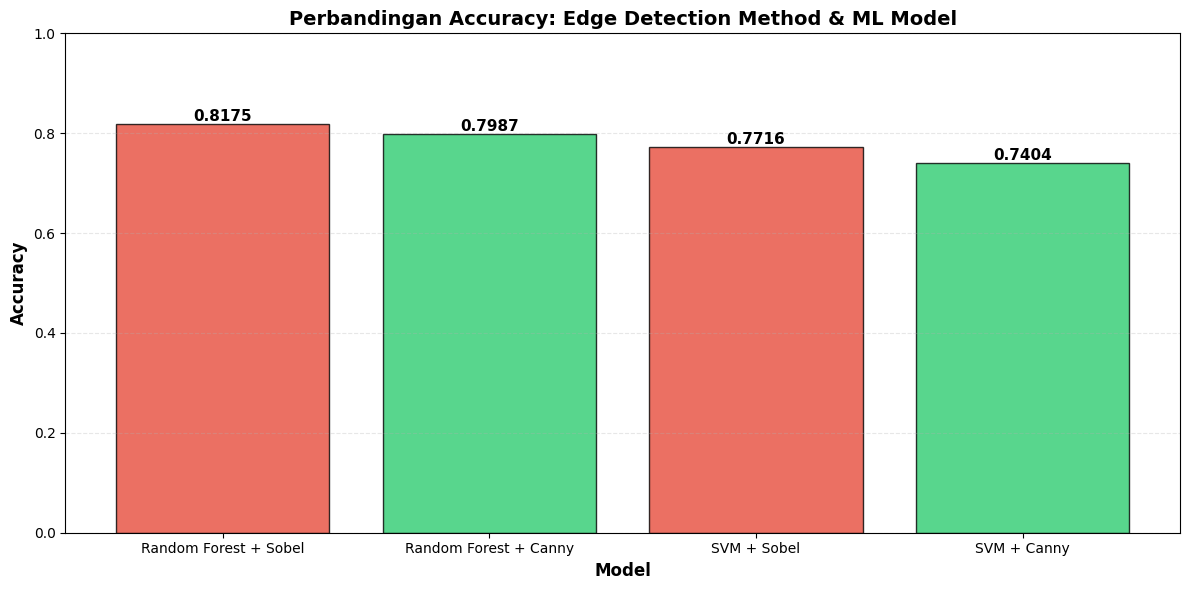

In [73]:
# Plot accuracy comparison
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#2ecc71' if 'Canny' in model else '#e74c3c' for model in comparison_df['Model']]
bars = ax.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Accuracy: Edge Detection Method & ML Model', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

plt.savefig(RESULTS_DIR / 'visualizations' / 'accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 13.2 Feature Importance Analysis

Analyze which features contribute most to classification to determine if we can reduce the feature set.

In [74]:
# Define feature names for interpretability
feature_names = [
    # Texture Features (12)
    'edge_density',
    'edge_mean', 'edge_std', 'edge_max',
    'edge_hist_0', 'edge_hist_1', 'edge_hist_2', 'edge_hist_3',
    'edge_hist_4', 'edge_hist_5', 'edge_hist_6', 'edge_hist_7',
    
    # Shape Features (4)
    'normalized_radius', 'center_x', 'center_y', 'circularity',
    
    # Edge Pattern Features (12)
    'orient_hist_0', 'orient_hist_1', 'orient_hist_2', 'orient_hist_3',
    'orient_hist_4', 'orient_hist_5', 'orient_hist_6', 'orient_hist_7',
    'magnitude_mean', 'magnitude_std', 'magnitude_p75', 'magnitude_p90',
    
    # Spatial Features (4)
    'quad_density_tl', 'quad_density_tr', 'quad_density_bl', 'quad_density_br',
    
    # Local Variance Features (3)
    'local_var_mean', 'local_var_std', 'local_var_p75'
]

print(f"Total features defined: {len(feature_names)}")

# Get feature importance from best Random Forest model (Sobel)
importances = rf_sobel.feature_importances_
indices = np.argsort(importances)[::-1]

# Create DataFrame for analysis
importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in indices],
    'Importance': importances[indices],
    'Rank': range(1, len(feature_names) + 1)
})

# Calculate cumulative importance
importance_df['Cumulative'] = importance_df['Importance'].cumsum()
importance_df['Cumulative_Pct'] = importance_df['Cumulative'] / importance_df['Importance'].sum() * 100

print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKING (Random Forest + Sobel)")
print("="*70)
print(importance_df.to_string(index=False))
print("="*70)

Total features defined: 35

FEATURE IMPORTANCE RANKING (Random Forest + Sobel)
          Feature  Importance  Rank  Cumulative  Cumulative_Pct
      edge_hist_1    0.094976     1    0.094976        9.497595
      edge_hist_0    0.052508     2    0.147484       14.748382
      edge_hist_2    0.050810     3    0.198294       19.829391
    magnitude_std    0.047767     4    0.246060       24.606048
    magnitude_p90    0.046315     5    0.292376       29.237596
    local_var_std    0.042109     6    0.334485       33.448502
      edge_hist_3    0.040392     7    0.374877       37.487715
        edge_mean    0.038624     8    0.413501       41.350098
    magnitude_p75    0.038602     9    0.452103       45.210266
    local_var_p75    0.037281    10    0.489384       48.938370
   local_var_mean    0.032348    11    0.521732       52.173218
    orient_hist_1    0.030108    12    0.551840       55.183994
    orient_hist_5    0.029811    13    0.581651       58.165065
    orient_hist_3    0.02

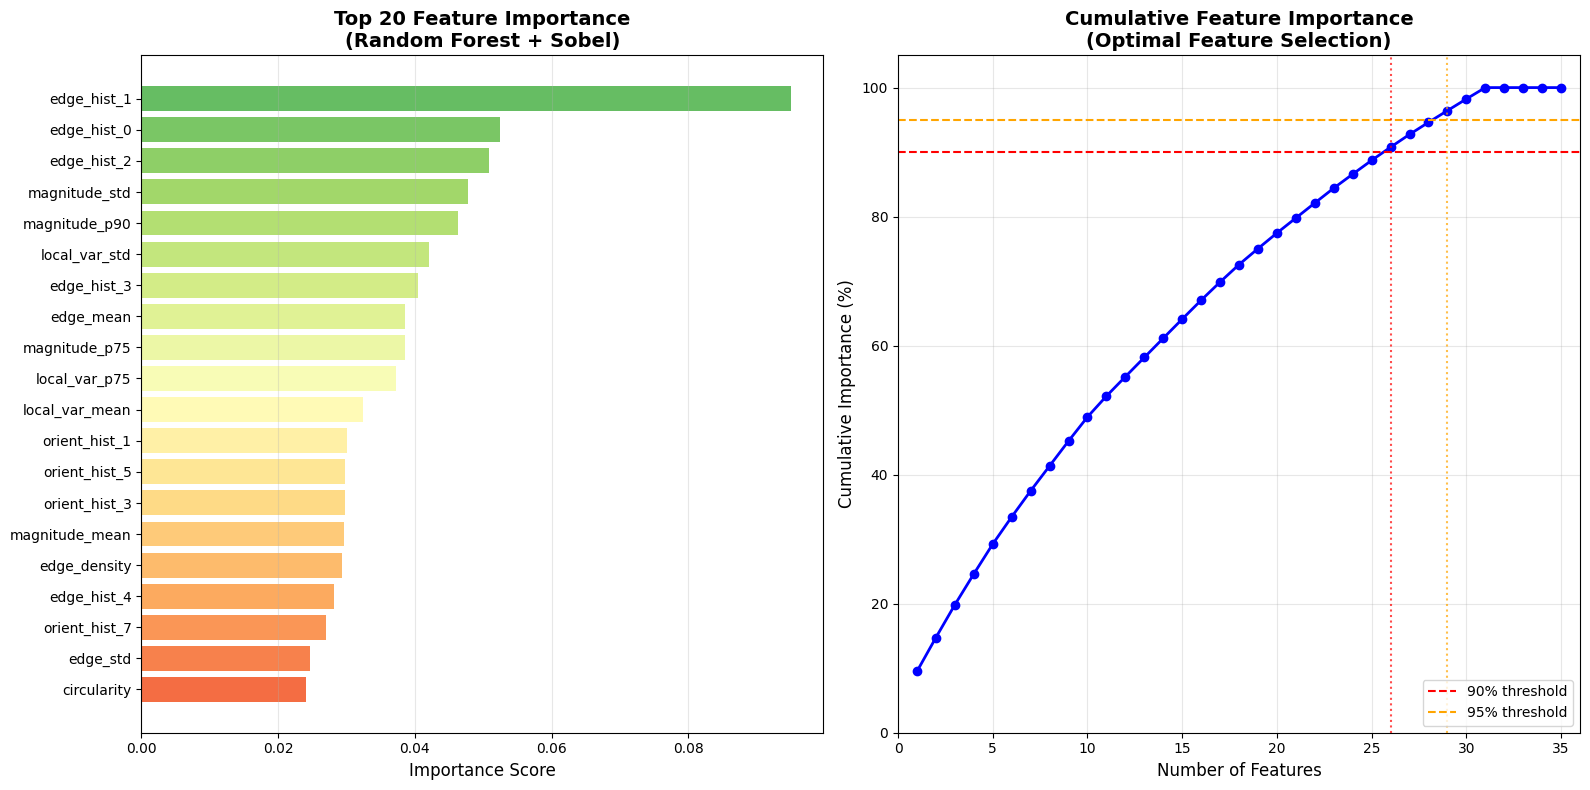


FEATURE SELECTION RECOMMENDATIONS:
   • Top 26 features capture 90% importance
   • Top 29 features capture 95% importance
   • Total features: 35


In [75]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Feature Importance Bar Chart (Top 20)
top_n = 20
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, top_n))
axes[0].barh(range(top_n), importance_df['Importance'].values[:top_n][::-1], color=colors[::-1])
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(importance_df['Feature'].values[:top_n][::-1])
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title(f'Top {top_n} Feature Importance\n(Random Forest + Sobel)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Cumulative Importance
axes[1].plot(range(1, len(feature_names) + 1), importance_df['Cumulative_Pct'].values, 
             'b-o', markersize=6, linewidth=2)
axes[1].axhline(y=90, color='r', linestyle='--', label='90% threshold')
axes[1].axhline(y=95, color='orange', linestyle='--', label='95% threshold')

# Find optimal cutoffs
n_features_90 = (importance_df['Cumulative_Pct'] >= 90).idxmax() + 1
n_features_95 = (importance_df['Cumulative_Pct'] >= 95).idxmax() + 1

axes[1].axvline(x=n_features_90, color='r', linestyle=':', alpha=0.7)
axes[1].axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.7)

axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12)
axes[1].set_title('Cumulative Feature Importance\n(Optimal Feature Selection)', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, len(feature_names) + 1)
axes[1].set_ylim(0, 105)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'feature_importance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFEATURE SELECTION RECOMMENDATIONS:")
print(f"   • Top {n_features_90} features capture 90% importance")
print(f"   • Top {n_features_95} features capture 95% importance")
print(f"   • Total features: {len(feature_names)}")

## 14. Confusion Matrix untuk Model Terbaik

Model terbaik: Random Forest + Sobel
Accuracy: 0.8175



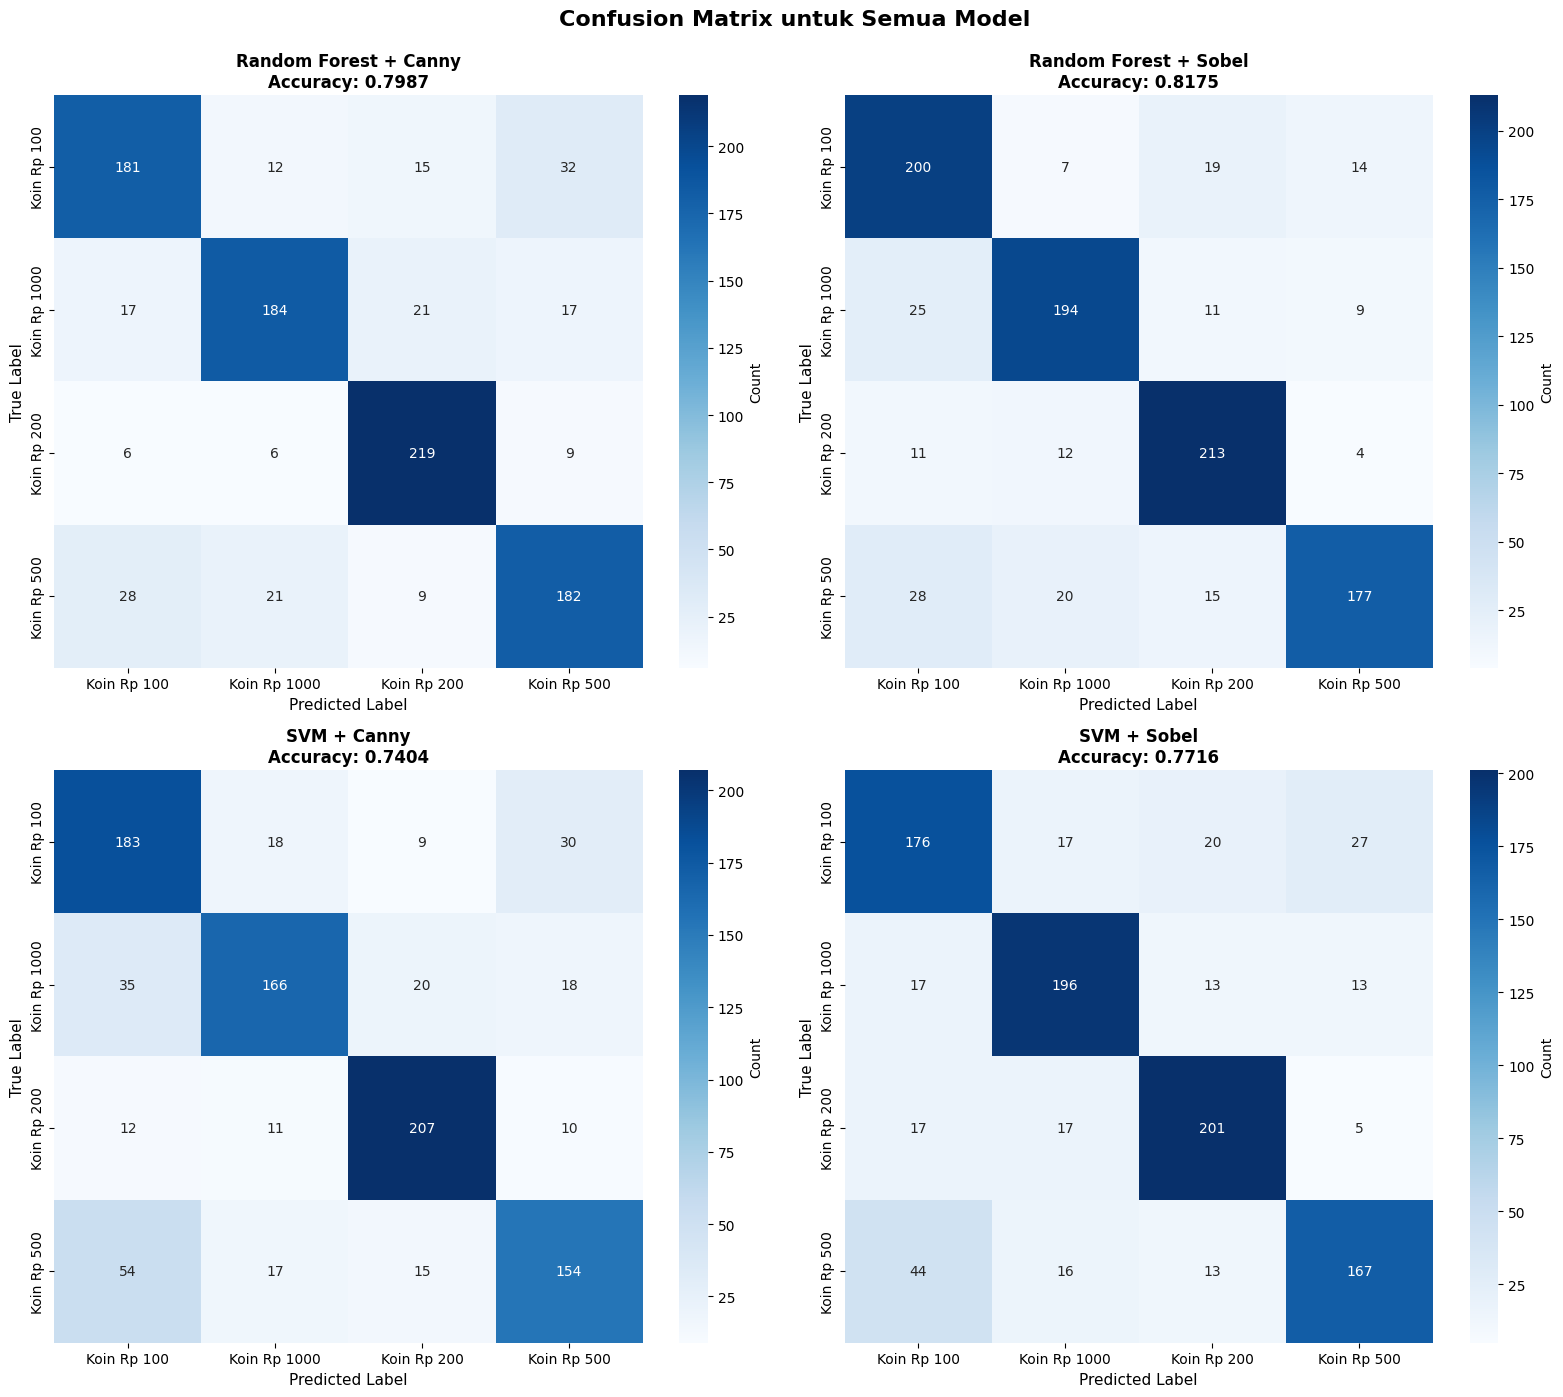

In [76]:
# Determine best model
best_model_row = comparison_df.iloc[0]
print(f"Model terbaik: {best_model_row['Model']}")
print(f"Accuracy: {best_model_row['Accuracy']:.4f}\n")

# Get predictions for all models
models_info = [
    ('Random Forest + Canny', y_test_canny, y_pred_rf_canny),
    ('Random Forest + Sobel', y_test_sobel, y_pred_rf_sobel),
    ('SVM + Canny', y_test_canny, y_pred_svm_canny),
    ('SVM + Sobel', y_test_sobel, y_pred_svm_sobel)
]

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (model_name, y_true, y_pred) in enumerate(models_info):
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': 'Count'})
    
    axes[idx].set_title(f'{model_name}\nAccuracy: {accuracy_score(y_true, y_pred):.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    axes[idx].set_ylabel('True Label', fontsize=11)

plt.suptitle('Confusion Matrix untuk Semua Model', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrix' / 'all_models_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 15. Analisis Per-Class Performance

In [77]:
from sklearn.metrics import precision_recall_fscore_support

models_info = [
    ('Random Forest + Canny', y_test_canny, y_pred_rf_canny),
    ('Random Forest + Sobel', y_test_sobel, y_pred_rf_sobel),
    ('SVM + Canny', y_test_canny, y_pred_svm_canny),
    ('SVM + Sobel', y_test_sobel, y_pred_svm_sobel)
]

per_class_results = []

for model_name, y_true, y_pred in models_info:
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names)), zero_division=0
    )
    
    for idx, cls_name in enumerate(class_names):
        per_class_results.append({
            'Model': model_name,
            'Class': cls_name,
            'Precision': precision[idx],
            'Recall': recall[idx],
            'F1-Score': f1[idx],
            'Support': support[idx]
        })

per_class_df = pd.DataFrame(per_class_results)

for cls_name in class_names:
    print(f"\n{cls_name}:")
    cls_data = per_class_df[per_class_df['Class'] == cls_name]
    print(cls_data[['Model', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

per_class_df.to_csv(RESULTS_DIR / 'per_class_performance.csv', index=False)


Koin Rp 100:
                Model  Precision   Recall  F1-Score
Random Forest + Canny   0.780172 0.754167  0.766949
Random Forest + Sobel   0.757576 0.833333  0.793651
          SVM + Canny   0.644366 0.762500  0.698473
          SVM + Sobel   0.692913 0.733333  0.712551

Koin Rp 1000:
                Model  Precision   Recall  F1-Score
Random Forest + Canny   0.825112 0.769874  0.796537
Random Forest + Sobel   0.832618 0.811715  0.822034
          SVM + Canny   0.783019 0.694561  0.736142
          SVM + Sobel   0.796748 0.820084  0.808247

Koin Rp 200:
                Model  Precision  Recall  F1-Score
Random Forest + Canny   0.829545  0.9125  0.869048
Random Forest + Sobel   0.825581  0.8875  0.855422
          SVM + Canny   0.824701  0.8625  0.843177
          SVM + Sobel   0.813765  0.8375  0.825462

Koin Rp 500:
                Model  Precision   Recall  F1-Score
Random Forest + Canny   0.758333 0.758333  0.758333
Random Forest + Sobel   0.867647 0.737500  0.797297
          SV

### 15.1 Visualisasi F1-Score per Class

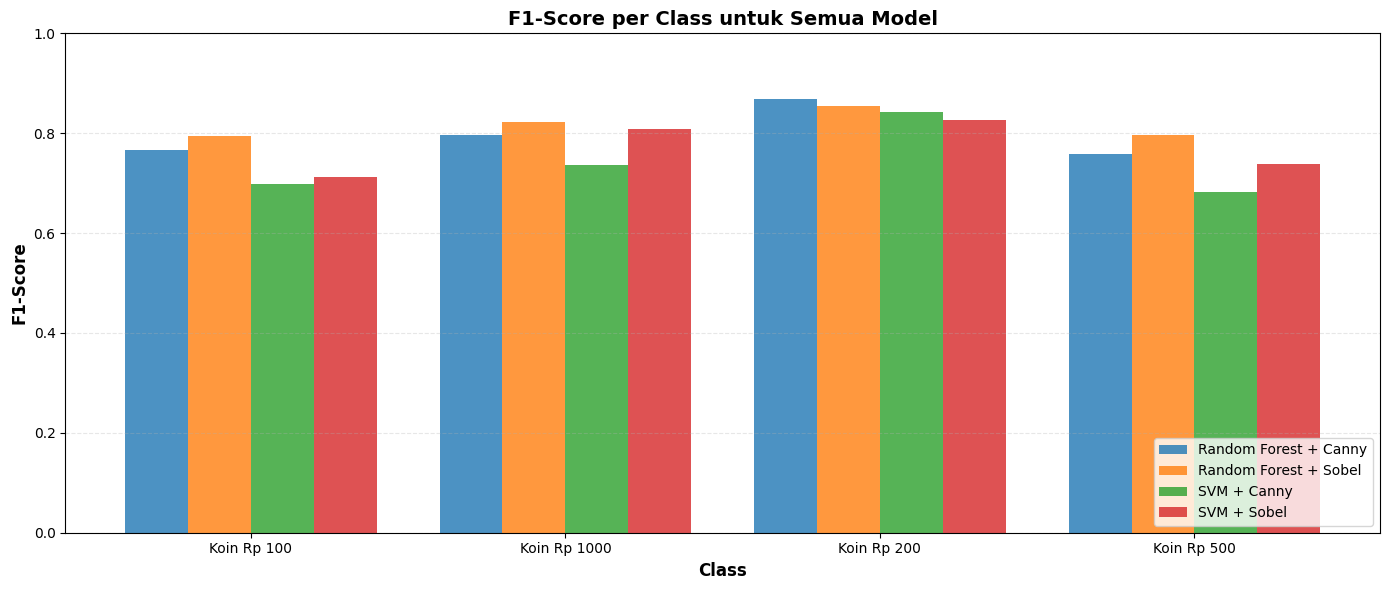

In [78]:
# Plot F1-Score per class for all models
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.2

for idx, (model_name, _, _) in enumerate(models_info):
    model_data = per_class_df[per_class_df['Model'] == model_name]
    f1_scores = model_data['F1-Score'].values
    
    offset = (idx - 1.5) * width
    ax.bar(x + offset, f1_scores, width, label=model_name, alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('F1-Score per Class untuk Semua Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=0)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

plt.savefig(RESULTS_DIR / 'visualizations' / 'f1_score_per_class.png', dpi=150, bbox_inches='tight')
plt.show()

## Analisis Kesalahan Prediksi

Analisis model terbaik (Random Forest + Sobel) untuk memahami karakteristik misclassification.

In [79]:
misclassified_indices = np.where(y_test_sobel != y_pred_rf_sobel)[0]
correct_indices = np.where(y_test_sobel == y_pred_rf_sobel)[0]

print(f"Total test samples: {len(y_test_sobel)}")
print(f"Correct: {len(correct_indices)} ({len(correct_indices)/len(y_test_sobel)*100:.2f}%)")
print(f"Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_test_sobel)*100:.2f}%)")

print("\nBreakdown per kelas:")
for cls_idx, cls_name in enumerate(class_names):
    class_mask = y_test_sobel == cls_idx
    class_total = np.sum(class_mask)
    class_misclassified = np.sum((y_test_sobel == cls_idx) & (y_pred_rf_sobel != cls_idx))
    
    print(f"  {cls_name}: {class_total} total, {class_misclassified} misclassified ({class_misclassified/class_total*100:.2f}%)")
    
    if class_misclassified > 0:
        misclass_mask = (y_test_sobel == cls_idx) & (y_pred_rf_sobel != cls_idx)
        predicted_as = y_pred_rf_sobel[misclass_mask]
        for pred_idx in range(len(class_names)):
            pred_count = np.sum(predicted_as == pred_idx)
            if pred_count > 0:
                print(f"      → {pred_count}x as {class_names[pred_idx]}")

Total test samples: 959
Correct: 784 (81.75%)
Misclassified: 175 (18.25%)

Breakdown per kelas:
  Koin Rp 100: 240 total, 40 misclassified (16.67%)
      → 7x as Koin Rp 1000
      → 19x as Koin Rp 200
      → 14x as Koin Rp 500
  Koin Rp 1000: 239 total, 45 misclassified (18.83%)
      → 25x as Koin Rp 100
      → 11x as Koin Rp 200
      → 9x as Koin Rp 500
  Koin Rp 200: 240 total, 27 misclassified (11.25%)
      → 11x as Koin Rp 100
      → 12x as Koin Rp 1000
      → 4x as Koin Rp 500
  Koin Rp 500: 240 total, 63 misclassified (26.25%)
      → 28x as Koin Rp 100
      → 20x as Koin Rp 1000
      → 15x as Koin Rp 200


In [80]:
def get_sample_images_for_misclassifications(dataset_dir, class_names, y_test, y_pred, 
                                              max_samples_per_class=3, edge_method='sobel'):
    """Get sample images for misclassified predictions"""
    misclass_indices = np.where(y_test != y_pred)[0]
    samples_per_class = {cls_idx: [] for cls_idx in range(len(class_names))}
    
    for idx in misclass_indices:
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        samples_per_class[true_label].append((true_label, pred_label))
    
    result = []
    
    for cls_idx, cls_name in enumerate(class_names):
        if len(samples_per_class[cls_idx]) == 0:
            continue
        
        cls_dir = dataset_dir / cls_name
        images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
        
        if len(images) == 0:
            continue
        
        num_samples = min(max_samples_per_class, len(samples_per_class[cls_idx]))
        
        for i in range(num_samples):
            if i < len(samples_per_class[cls_idx]):
                true_label, pred_label = samples_per_class[cls_idx][i]
                
                np.random.seed(RANDOM_SEED + cls_idx + i)
                img_path = np.random.choice(images)
                
                img = cv2.imread(str(img_path))
                if img is None:
                    continue
                
                img_resized = cv2.resize(img, IMAGE_SIZE)
                seg, circle_info, edges = detect_and_segment_coin(img_resized, edge_method)
                
                if circle_info is not None:
                    result.append({
                        'image': img_resized,
                        'true_label': true_label,
                        'pred_label': pred_label,
                        'edges': edges,
                        'circle_info': circle_info
                    })
    
    return result

In [81]:
misclassified_samples = get_sample_images_for_misclassifications(
    DATASET_DIR, class_names, y_test_sobel, y_pred_rf_sobel,
    max_samples_per_class=2, edge_method='sobel'
)

print(f"Visualizing {len(misclassified_samples)} misclassified samples...")

Visualizing 8 misclassified samples...


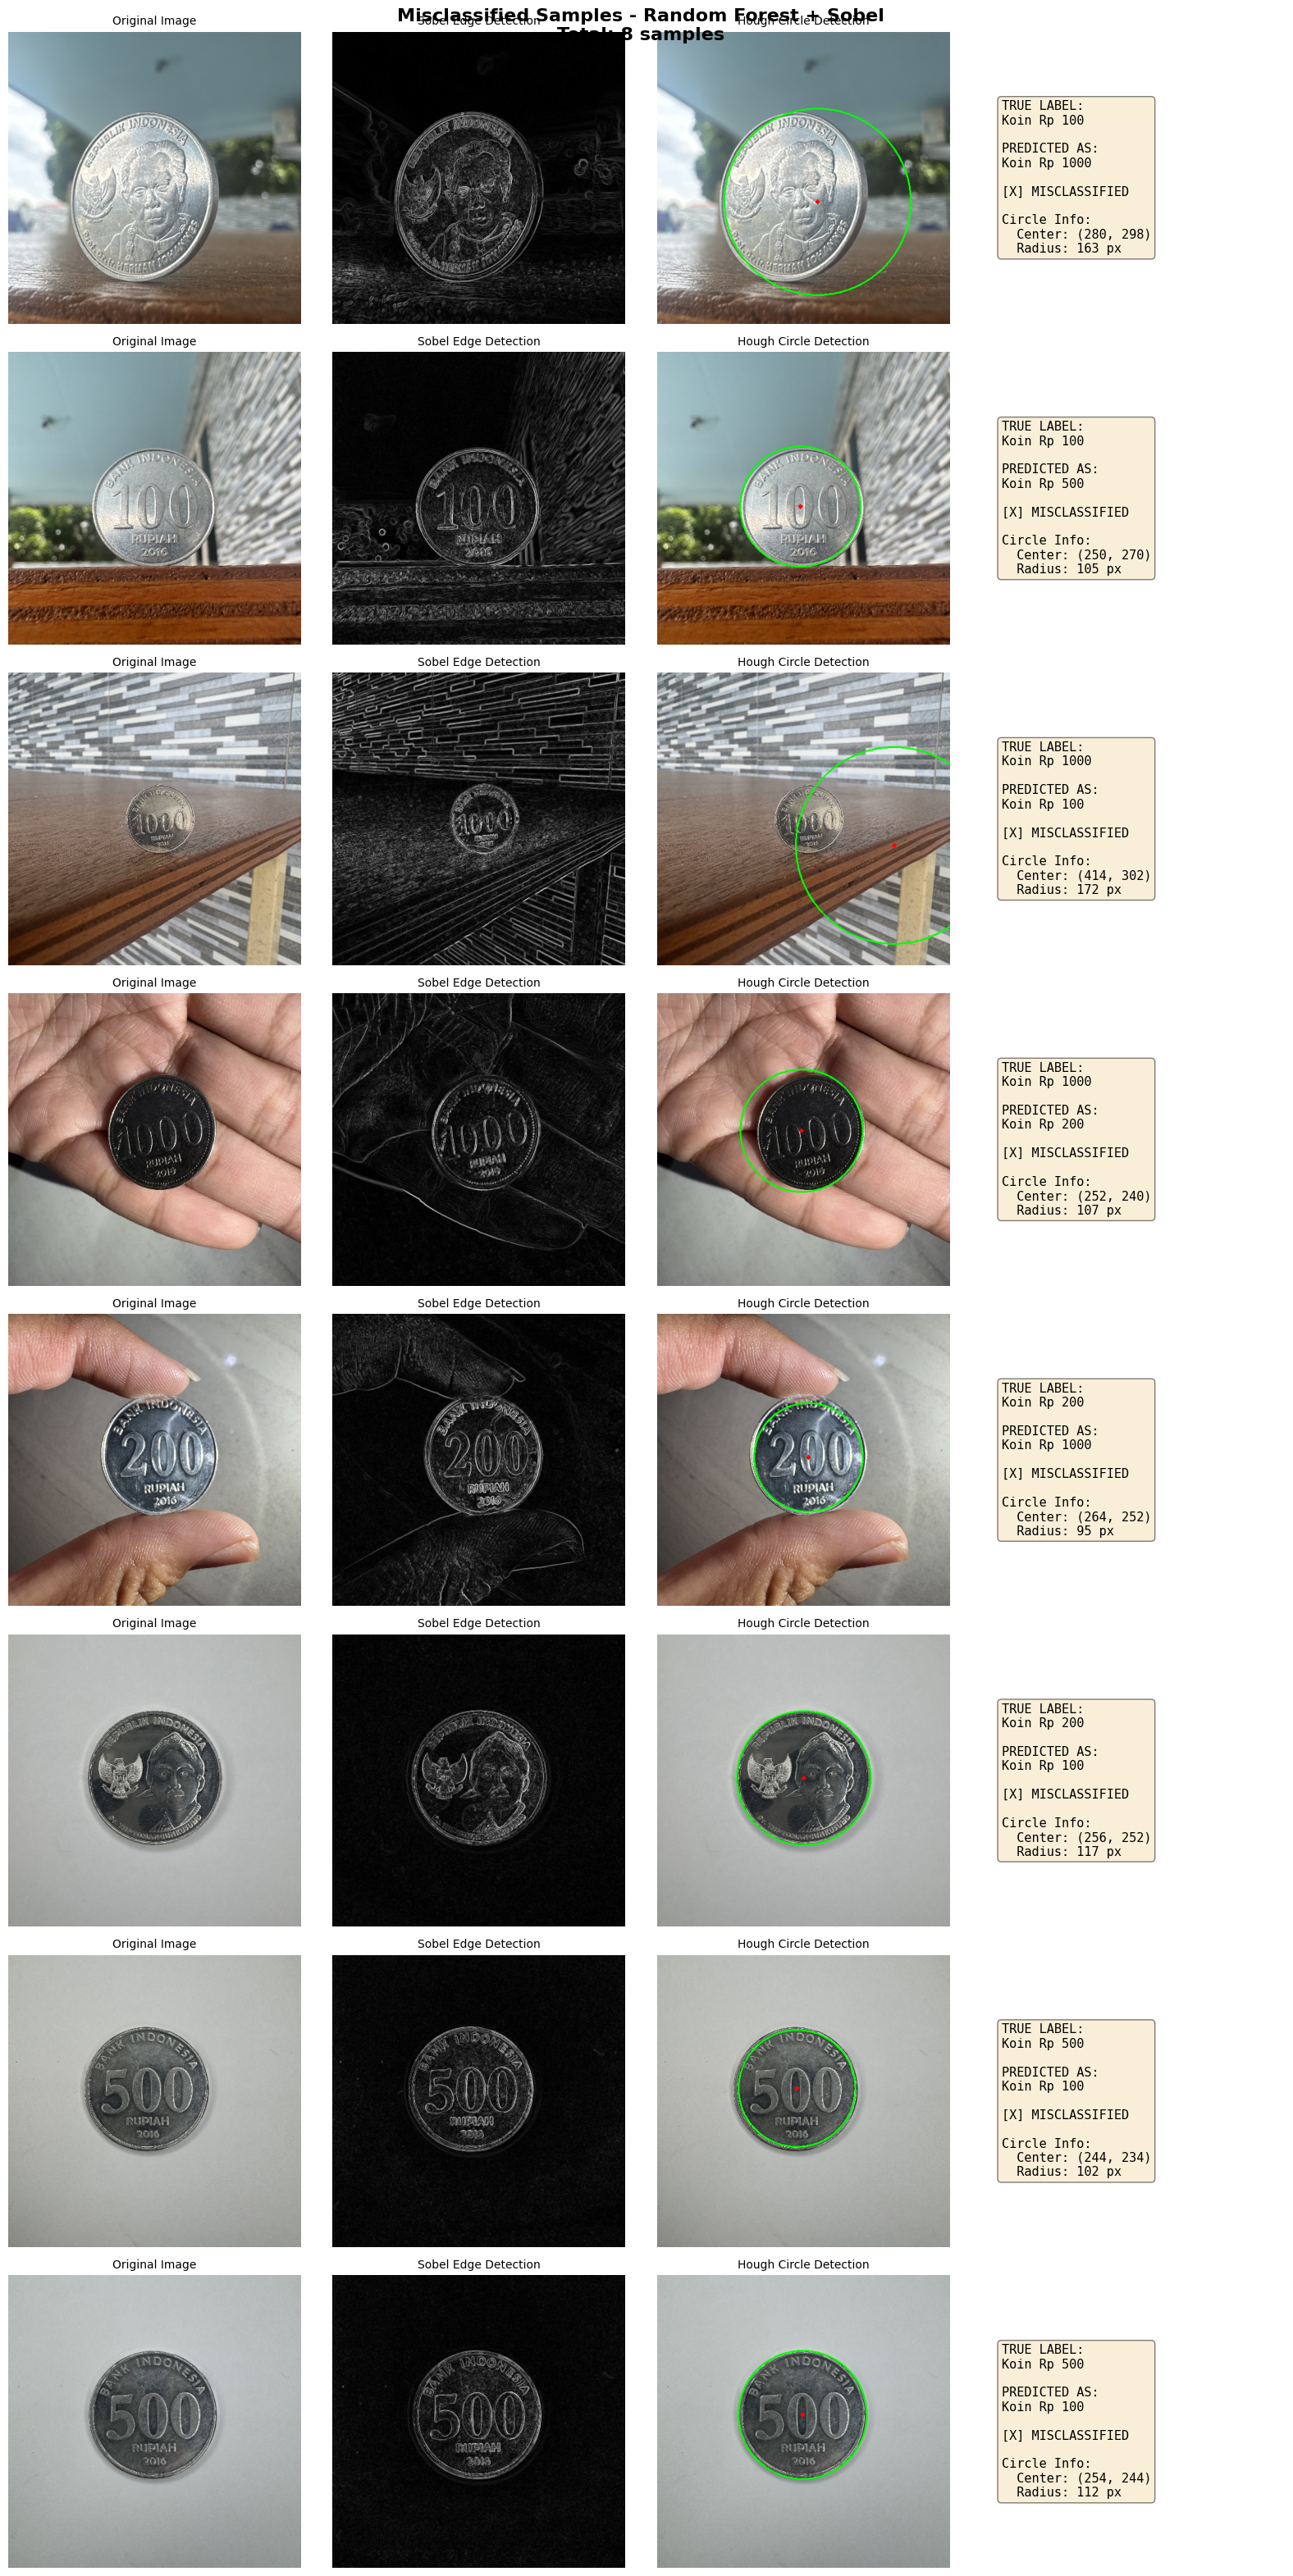


[OK] Visualisasi 8 sample yang salah diprediksi telah dibuat!
   Disimpan di: D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\coin_classification\visualizations\misclassified_samples.png


In [82]:
# Visualisasi gambar yang salah diprediksi
if len(misclassified_samples) > 0:
    num_samples = len(misclassified_samples)
    cols = 4  # Original, Edges, Circle Detection, Info text
    
    fig, axes = plt.subplots(num_samples, cols, figsize=(16, num_samples * 4))
    
    # Handle case when only 1 row
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample in enumerate(misclassified_samples):
        img = sample['image']
        true_label = sample['true_label']
        pred_label = sample['pred_label']
        edges = sample['edges']
        circle_info = sample['circle_info']
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Draw circle
        img_with_circle = img.copy()
        if circle_info:
            x, y, r = circle_info
            cv2.circle(img_with_circle, (x, y), r, (0, 255, 0), 2)
            cv2.circle(img_with_circle, (x, y), 2, (0, 0, 255), 3)
        
        # Column 1: Original image
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].set_title('Original Image', fontsize=10)
        axes[idx, 0].axis('off')
        
        # Column 2: Sobel edges
        axes[idx, 1].imshow(edges, cmap='gray')
        axes[idx, 1].set_title('Sobel Edge Detection', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Column 3: Circle detection
        axes[idx, 2].imshow(cv2.cvtColor(img_with_circle, cv2.COLOR_BGR2RGB))
        axes[idx, 2].set_title('Hough Circle Detection', fontsize=10)
        axes[idx, 2].axis('off')
        
        # Column 4: Info text
        axes[idx, 3].axis('off')
        info_text = f"TRUE LABEL:\n{class_names[true_label]}\n\n"
        info_text += f"PREDICTED AS:\n{class_names[pred_label]}\n\n"
        info_text += f"[X] MISCLASSIFIED\n\n"
        
        if circle_info:
            x, y, r = circle_info
            info_text += f"Circle Info:\n"
            info_text += f"  Center: ({x}, {y})\n"
            info_text += f"  Radius: {r} px"
        else:
            info_text += "Circle: Not detected"
        
        axes[idx, 3].text(0.1, 0.5, info_text, 
                         fontsize=11, 
                         verticalalignment='center',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                         family='monospace')
    
    plt.suptitle(f'Misclassified Samples - Random Forest + Sobel\nTotal: {num_samples} samples', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'visualizations' / 'misclassified_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n[OK] Visualisasi {num_samples} sample yang salah diprediksi telah dibuat!")
    print(f"   Disimpan di: {RESULTS_DIR / 'visualizations' / 'misclassified_samples.png'}")
else:
    print("Tidak ada sample yang salah diprediksi! Model perfect!")

In [83]:
from collections import defaultdict

confusion_pairs = defaultdict(int)

for idx in misclassified_indices:
    true_label = y_test_sobel[idx]
    pred_label = y_pred_rf_sobel[idx]
    pair = f"{class_names[true_label]} → {class_names[pred_label]}"
    confusion_pairs[pair] += 1

print("Top confusion pairs:")
sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
for pair, count in sorted_pairs[:10]:
    print(f"  {pair}: {count}x")

Top confusion pairs:
  Koin Rp 500 → Koin Rp 100: 28x
  Koin Rp 1000 → Koin Rp 100: 25x
  Koin Rp 500 → Koin Rp 1000: 20x
  Koin Rp 100 → Koin Rp 200: 19x
  Koin Rp 500 → Koin Rp 200: 15x
  Koin Rp 100 → Koin Rp 500: 14x
  Koin Rp 200 → Koin Rp 1000: 12x
  Koin Rp 1000 → Koin Rp 200: 11x
  Koin Rp 200 → Koin Rp 100: 11x
  Koin Rp 1000 → Koin Rp 500: 9x


## Save Model Terbaik (Hybrid Features)

In [84]:
import pickle

MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(exist_ok=True)

# Determine best model from comparison
best_model_row = comparison_df.iloc[0]
print(f"Best Model: {best_model_row['Model']}")
print(f"Accuracy: {best_model_row['Accuracy']:.4f}\n")

# Save the best model (Random Forest + Sobel with Hybrid features)
best_model_name = 'random_forest_hybrid'

model_path = MODELS_DIR / f'{best_model_name}_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_sobel, f)

scaler_path = MODELS_DIR / f'{best_model_name}_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler_rf_sobel, f)

print(f"Model saved: {model_path.relative_to(BASE_DIR)}")
print(f"Scaler saved: {scaler_path.relative_to(BASE_DIR)}")
print(f"Accuracy: {acc_rf_sobel:.4f}")
print(f'\nTest: python src/test_model.py "path/to/coin_image.jpg" --save-steps')

Best Model: Random Forest + Sobel
Accuracy: 0.8175

Model saved: models\random_forest_hybrid_model.pkl
Scaler saved: models\random_forest_hybrid_scaler.pkl
Accuracy: 0.8175

Test: python src/test_model.py "path/to/coin_image.jpg" --save-steps
